# Homework 1 : CUAHSI VU : Snow Hydrology

We'll use the setup from the `homework_1_C_setup.ipynb` notebook for this exercise as well. If you think that you comprised that setup in the previous exercise, just rerun `homework_1_C_setup.ipynb` before continuing.

## E. Homework 1 Exercise 2

### Modify the albedo formulation

In this exercise we will modify the albedo formulation and the parameters that govern that formulation. For background to this exercise see Clark et al. (2015). You should examine the following three scenarios:

* Use a variable decay rate for the snow albedo. Note that this is the same as the default case used in the Homework 1 Exercise 1, so you actually already have these results. In this case the `alb_method` decision is set to `varDecay`.

* Use a constant decay rate for the snow albedo (but use the same parameters as for the variable decay rate). In this case, set `alb_method` to `conDecay`.

* Use a constant decay rate for the snow albedo and use appropriate parameters. So set `alb_method` to `conDecay` and set the following parameters in the local parameter file.
```
albedoDecayRate           |     360000.0 |     100000.0 |    5000000.0  
```

In [1]:
# Import the necessary packages
import pysumma
import xarray
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create variable shorthands for each netcdf output file
data_dir = '/home/jovyan/work/homework_1/data'

varDecay = data_dir + '/reynolds_output_CLM_2010_timestep.nc'
conDecay_param = data_dir + '/reynolds_output_conDecay_par_timestep.nc'
conDecay = data_dir + '/reynolds_output_conDecay_timestep.nc'

albs = [varDecay, conDecay, conDecay_param]  

layer_labels = ["Default - variable decay", "Constant decay", "Constant decay - parameters changed"]
titles = ["SWE", "Density", "Snow Surface Temperature", "Drainage Rate"]
y_labels = ["Snow Water Equivalent [kg m-2]", "Snow Density [kg m-3]", "Snow Surface Temperature [K]", "Drainage Rate [m s-1]"]

In [3]:
# Define functions

# Extract data into xarray
def getData(this_opt):
    data_xr = xarray.open_dataset(this_opt)
    SWE_xr = data_xr.scalarSWE
    depth_xr = data_xr.scalarSnowDepth
    sst_xr = data_xr.scalarSurfaceTemp
    density_xr = SWE_xr/depth_xr
    dr_xr = data_xr.scalarSnowDrainage
    
    return data_xr, SWE_xr, depth_xr, sst_xr, density_xr, dr_xr
    

# Convert xarrays to dataframes
def createDataframe(this_opt):
    data_xr = xarray.open_dataset(this_opt)
    df_SWE = data_xr.scalarSWE.to_dataframe()
    df_SWE=df_SWE.reset_index(level='hru')
    df_SWE.drop(['hru'], 1, inplace=True)

    df_depth = data_xr.scalarSnowDepth.to_dataframe()
    df_depth=df_depth.reset_index(level='hru')
    df_depth.drop(['hru'], 1, inplace=True)

    df_sst = data_xr.scalarSurfaceTemp.to_dataframe()
    df_sst=df_sst.reset_index(level='hru')
    df_sst.drop(['hru'], 1, inplace=True)

    df_dr = data_xr.scalarSnowDrainage.to_dataframe()
    df_dr=df_dr.reset_index(level='hru')
    df_dr.drop(['hru'], 1, inplace=True)
    
    return df_SWE, df_depth, df_sst, df_dr

# Subset xarrays and convert to dataframe
def sub_createDf(this_opt, start, stop):
    data_xr = xarray.open_dataset(this_opt)
       
    df_SWE = data_xr.scalarSWE.loc[start:stop].to_dataframe()
    df_SWE=df_SWE.reset_index(level='hru')
    df_SWE.drop(['hru'], 1, inplace=True)

    df_depth = data_xr.scalarSnowDepth.loc[start:stop].to_dataframe()
    df_depth=df_depth.reset_index(level='hru')
    df_depth.drop(['hru'], 1, inplace=True)

    df_sst = data_xr.scalarSurfaceTemp.loc[start:stop].to_dataframe()
    df_sst=df_sst.reset_index(level='hru')
    df_sst.drop(['hru'], 1, inplace=True)

    df_dr = data_xr.scalarSnowDrainage.loc[start:stop].to_dataframe()
    df_dr=df_dr.reset_index(level='hru')
    df_dr.drop(['hru'], 1, inplace=True)
    
    return df_SWE, df_depth, df_sst, df_dr

# Compile extracted data into a list of xarrays
def compileList():
    data_list = []
    SWE_list = []
    depth_list = []
    sst_list = []
    density_list = []
    dr_list = []
    for simulation in albs:
        data_xr, SWE_xr, depth_xr, sst_xr, density_xr, dr_xr = getData(simulation)
        data_list.append(data_xr)
        SWE_list.append(SWE_xr)
        depth_list.append(depth_xr)
        sst_list.append(sst_xr)
        density_list.append(density_xr)
        dr_list.append(dr_xr)
    return(data_list, SWE_list, depth_list, sst_list, density_list, dr_list)

# Define a plotting function based off of xarray functionality
def plotMe(this_xr_list, this_var, opt_lims):
    for i in range(0,len(this_xr_list)):
        xr = this_xr_list[i]
        if i == 0:
            xr.isel(hru=0).plot(label=layer_labels[i], color="dodgerblue", aspect=3, size=8)
        elif i == 1:            
            xr.isel(hru=0).plot(label=layer_labels[i], color="orangered", linewidth=2)
        elif i == 2:            
            xr.isel(hru=0).plot(label=layer_labels[i], color="mediumblue")
    if opt_lims is not None:
        low, high = opt_lims
        plt.ylim(low, high)
    plt.title(titles[this_var-1])
    plt.ylabel(y_labels[this_var-1])
    plt.xlabel("")
    plt.grid()
    plt.legend()

# Define a zoom function to subset lists of xarrays
def zoomIn(startDate, stopDate, all_var_list):    
    SWE_list_zm = []
    depth_list_zm = []
    sst_list_zm = []
    density_list_zm = []
    dr_list_zm=[]

    count = 0
    for this_xr_list in all_var_list:
        sub_list = []
        for xr in this_xr_list:
            xr_sub = xr.loc[start:stop]
            sub_list.append(xr_sub)
        if count == 0:
            SWE_list_zm = sub_list.copy()
        elif count == 1:
            depth_list_zm = sub_list.copy()
        elif count == 2:
            sst_list_zm = sub_list.copy()
        elif count == 3:
            density_list_zm = sub_list.copy()
        elif count == 4:
            dr_list_zm = sub_list.copy()
        count = count+1
            
    return(SWE_list_zm, depth_list_zm, sst_list_zm, density_list_zm, dr_list_zm) 

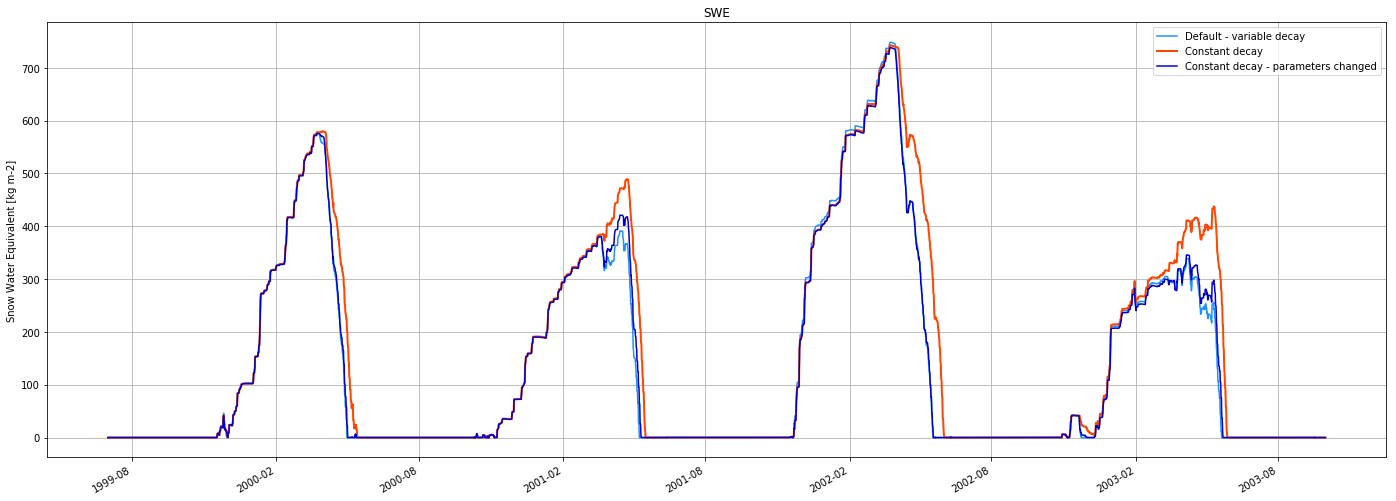

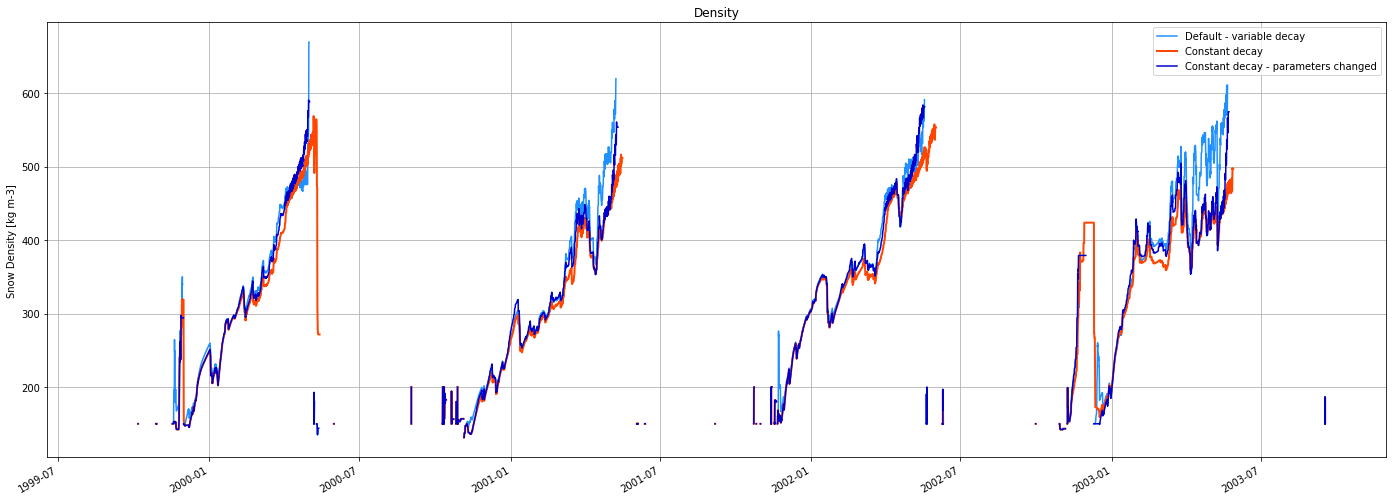

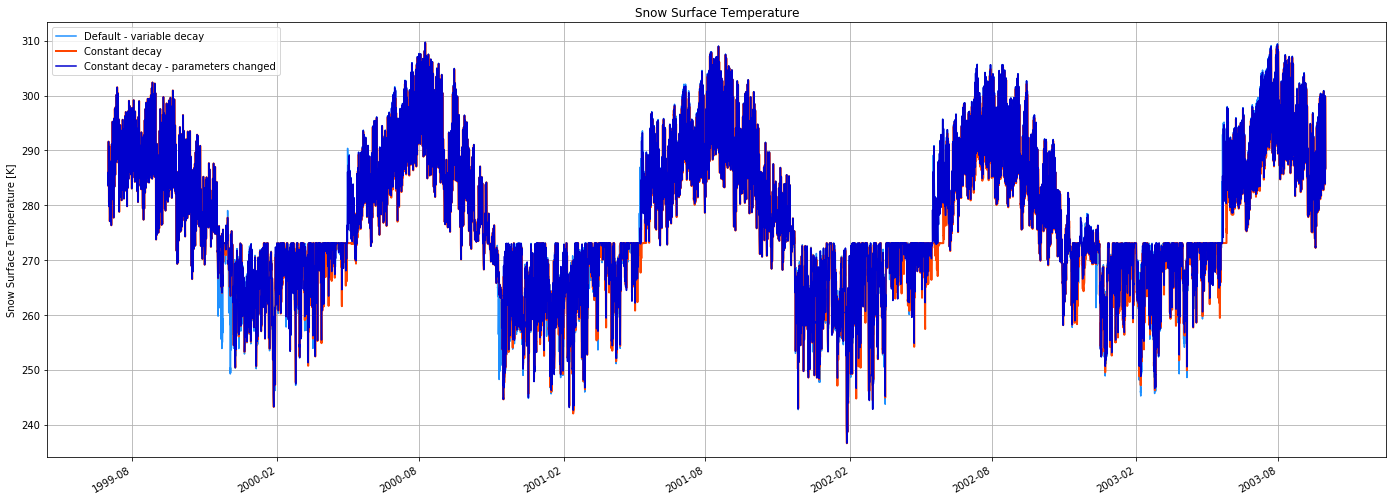

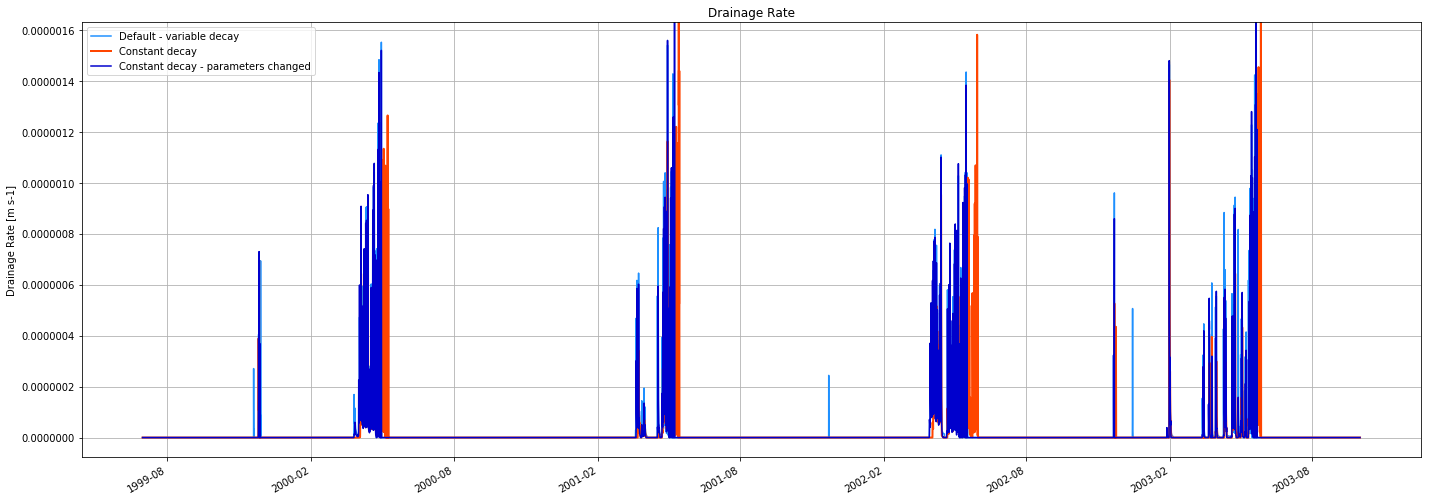

In [4]:
# Extract all the variables for all the simulations
data_list, SWE_list, depth_list, sst_list, density_list, dr_list = compileList()
all_var_list = [SWE_list, depth_list, sst_list, density_list, dr_list]

# Plot full date range for Reynolds Creek
# Plot it!
plotMe(SWE_list, 1, None)
plotMe(density_list, 2, None)
plotMe(sst_list, 3, None)
plotMe(dr_list, 4, None)

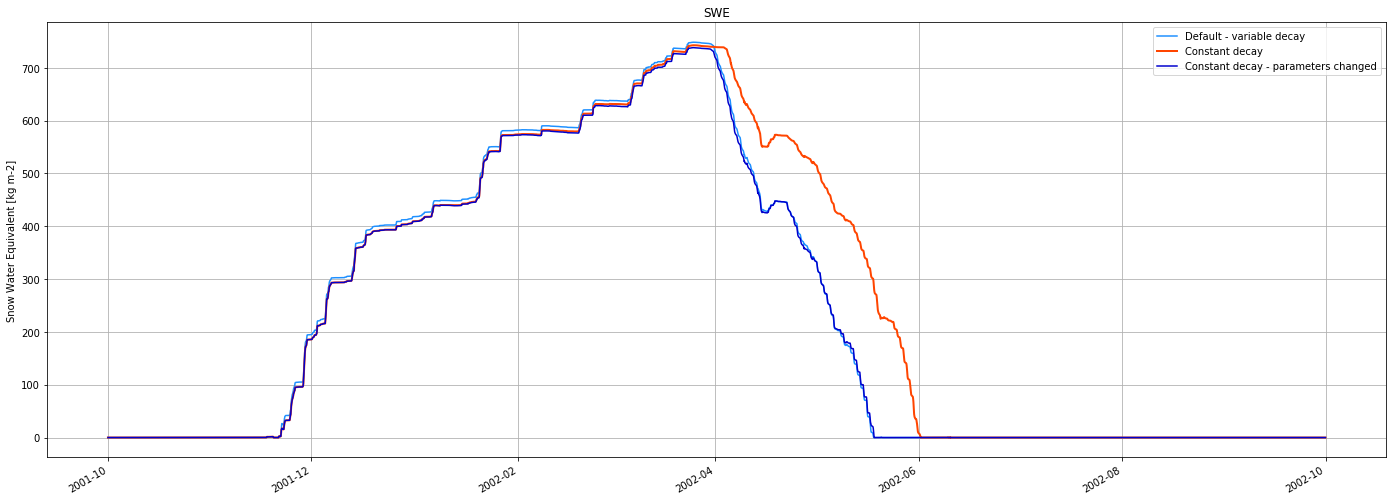

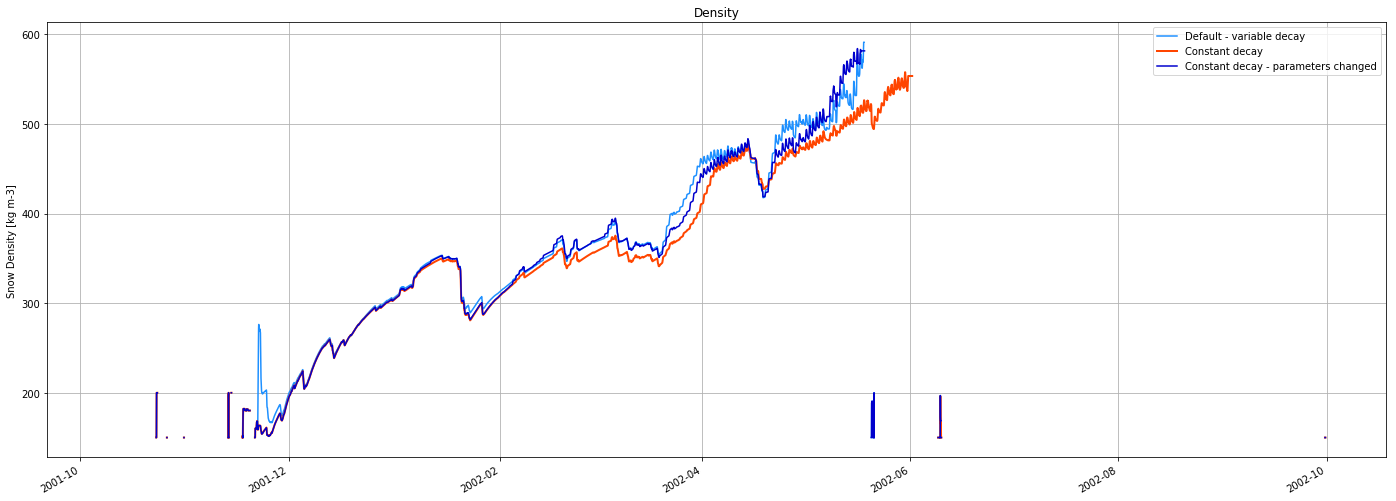

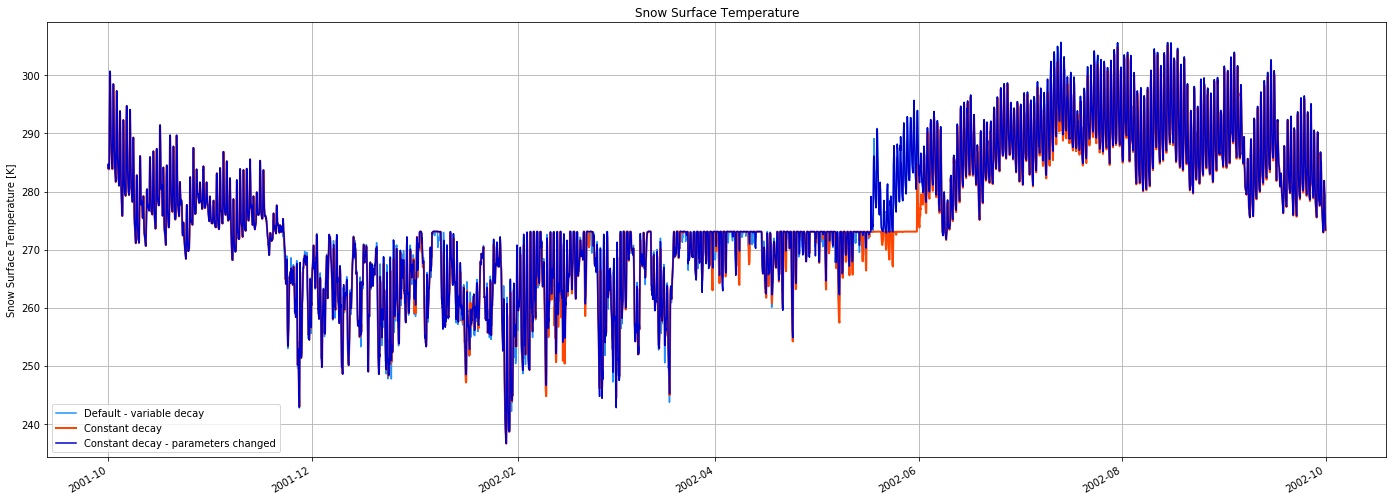

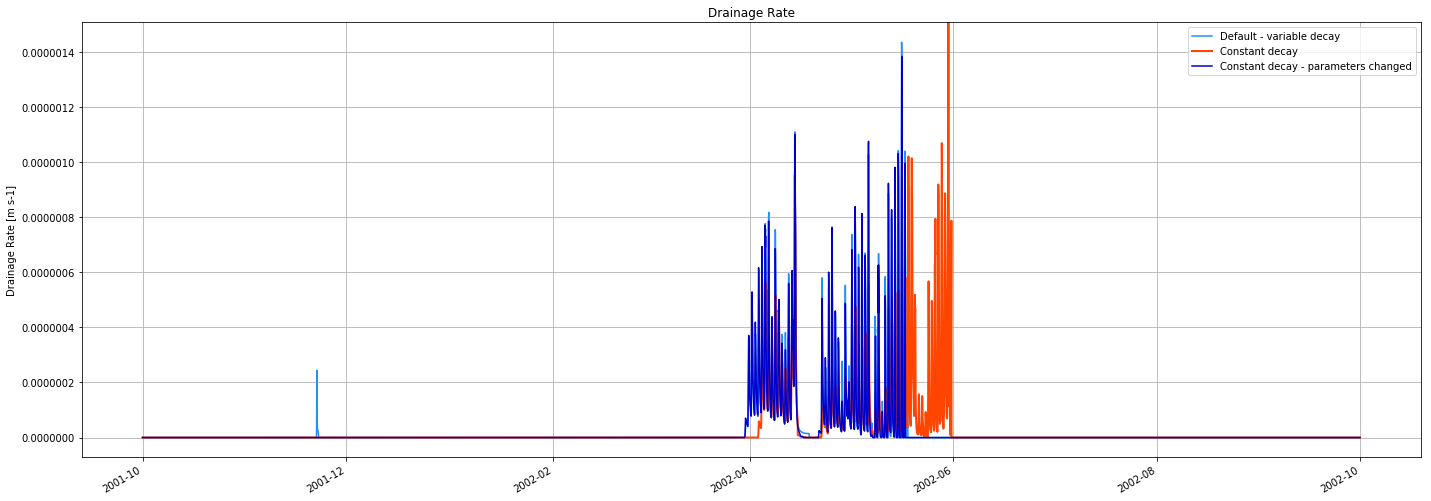

In [5]:
# Check out WY 2002
start = '2001-10-01'
stop = '2002-09-30'      

# Subset and extract xarray variable lists by date range
SWE_list_zm, depth_list_zm, sst_list_zm, density_list_zm, dr_list_zm = zoomIn(start, stop, all_var_list)

# Plot it!
plotMe(SWE_list_zm, 1, None)
plotMe(density_list_zm, 2, None)
plotMe(sst_list_zm, 3, None)
plotMe(dr_list_zm, 4, None)

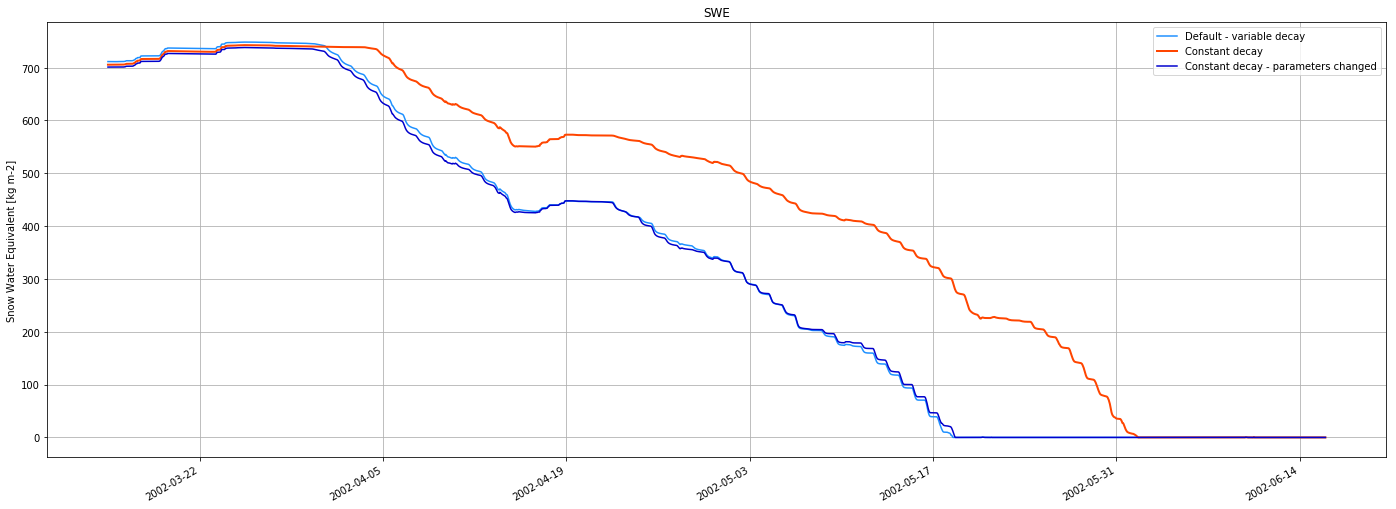

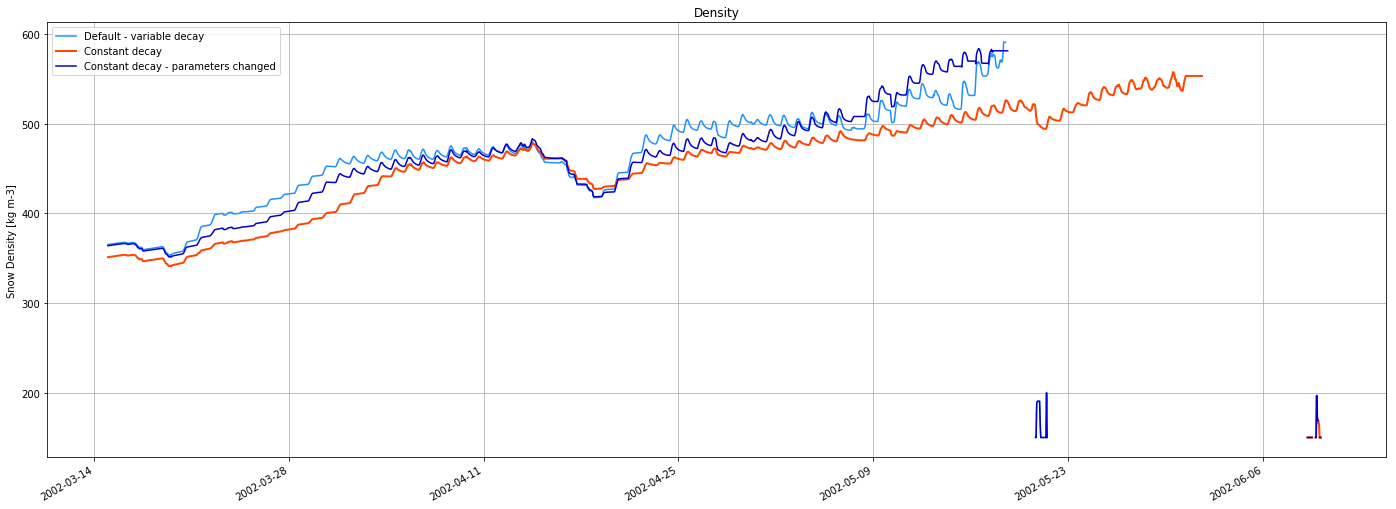

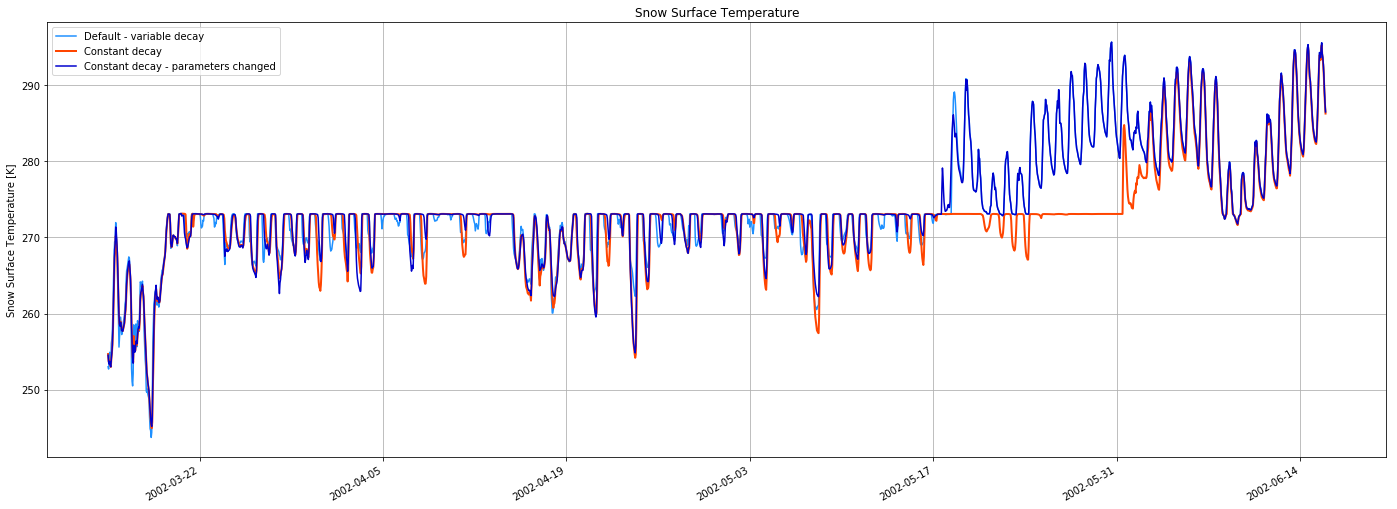

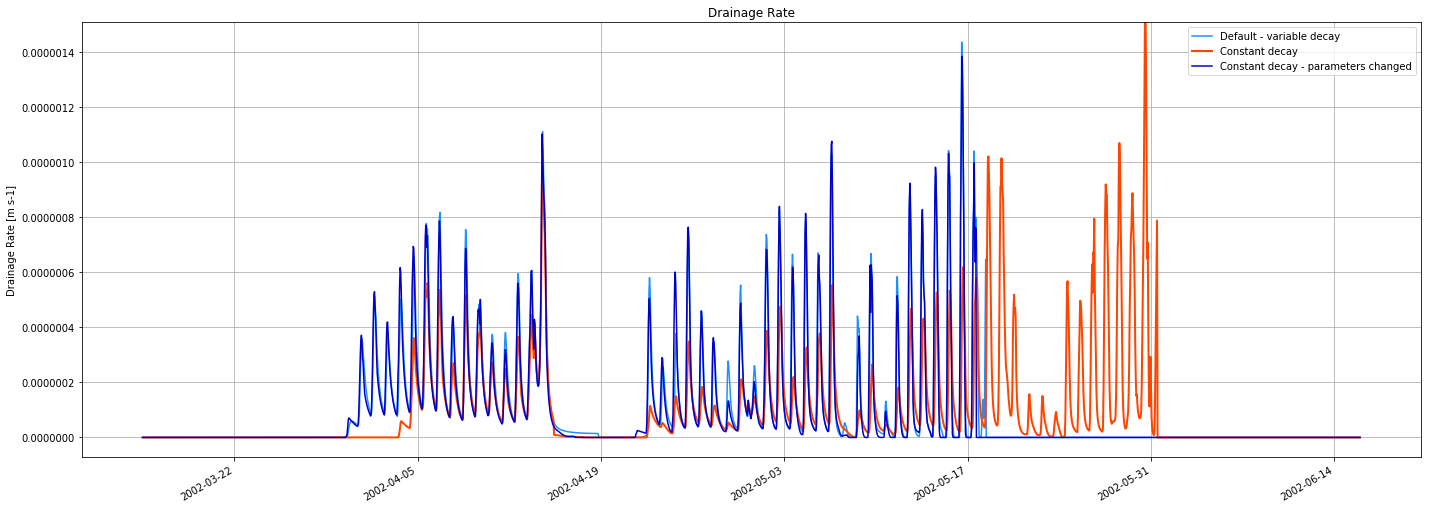

In [6]:
# Re-plot for ablation season
start = '2002-03-15'
stop = '2002-06-15'      

SWE_list_zm, depth_list_zm, sst_list_zm, density_list_zm, dr_list_zm = zoomIn(start, stop, all_var_list)

# Plot it!
plotMe(SWE_list_zm, 1, None)
plotMe(density_list_zm, 2, None)
plotMe(sst_list_zm, 3, None)
plotMe(dr_list_zm, 4, None)

## **Modification of Friedrich Knuth's bokeh plotting code**

In [7]:
# For analysis
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
import numpy as np

# For Bokeh plotting
from bokeh.plotting import figure, output_file, reset_output, show, ColumnDataSource, save
from bokeh.layouts import column, gridplot
from bokeh.models import BoxAnnotation
from bokeh.io import output_notebook

In [8]:
# print(type(df_SWE_var))

In [9]:
# Check out just WY 2002 and create the dataframes!
start = '2001-10-01'
stop = '2002-09-30'     

df_SWE_var, df_depth_var, df_sst_var, df_dr_var = sub_createDf(varDecay, start, stop)
df_SWE_con, df_depth_con, df_sst_con, df_dr_con = sub_createDf(conDecay, start, stop)
df_SWE_con_par, df_depth_con_par, df_sst_con_par, df_dr_con_par = sub_createDf(conDecay_param, start, stop)


In [10]:
# Combine the dataframes for all simulations by variable

# SWE
swe_runs_combine = pd.concat([df_SWE_var, 
                              df_SWE_con, 
                              df_SWE_con_par], axis=1)
swe_runs_combine.columns=['variable decay', 'constant decay', 'constant decay - parameters']

# Depth
depth_runs_combine = pd.concat([df_depth_var, 
                              df_depth_con, 
                              df_depth_con_par], axis=1)
depth_runs_combine.columns=['variable decay', 'constant decay', 'constant decay - parameters']

# SST
sst_runs_combine = pd.concat([df_sst_var, 
                              df_sst_con, 
                              df_sst_con_par], axis=1)
sst_runs_combine.columns=['variable decay', 'constant decay', 'constant decay - parameters']

# Drainage
dr_runs_combine = pd.concat([df_dr_var, 
                              df_dr_con, 
                              df_dr_con_par], axis=1)
dr_runs_combine.columns=['variable decay', 'constant decay', 'constant decay - parameters']




# Single interactive plot of SWE

In [11]:
source = ColumnDataSource(
    data = dict(
        x = list(swe_runs_combine.index.values),
        y0 = list(swe_runs_combine['variable decay'].values),
        y1 = list(swe_runs_combine['constant decay'].values),
        y2 = list(swe_runs_combine['constant decay - parameters'].values),
    )
)

s = figure(width = 1200,
           height = 400,
           x_axis_type = 'datetime',
           title='Snow Water Equivalent',
           x_axis_label='Time',
           y_axis_label="Snow water equivalent \n (instant) [kg m-2]")


s.line('x', 'y0', source=source, line_width=1,  line_color="blue", legend="variable decay")
s.line('x', 'y1', source=source, line_width=1, line_color="orange", legend="constant decay")
s.line('x', 'y2', source=source, line_width=1, line_color="green", legend="constant decay - parameters")

output_notebook()
show(column(s))

Loading BokehJS ...

# Single interactive plot of drainage

In [12]:
source = ColumnDataSource(
    data = dict(
        x = list(dr_runs_combine.index.values),
        y0 = list(dr_runs_combine['variable decay'].values),
        y1 = list(dr_runs_combine['constant decay'].values),
        y2 = list(dr_runs_combine['constant decay - parameters'].values),
    )
)

s = figure(width = 1200,
           height = 400,
           x_axis_type = 'datetime',
           title='Drainage from Snow Profile',
           x_axis_label='Time',
           y_axis_label="Drainage from the bottom of the snow profile \n (instant) [m s-1]")


s.line('x', 'y0', source=source, line_width=1,  line_color="blue", legend="variable decay")
s.line('x', 'y1', source=source, line_width=1, line_color="orange", legend="constant decay")
s.line('x', 'y2', source=source, line_width=1, line_color="green", legend="constant decay - parameters")

output_notebook()
show(column(s))

Loading BokehJS ...

# Single interactive plot of snow surface temperature

In [15]:
source = ColumnDataSource(
    data = dict(
        x = list(sst_runs_combine.index.values),
        y0 = list(sst_runs_combine['variable decay'].values),
        y1 = list(sst_runs_combine['constant decay'].values),
        y2 = list(sst_runs_combine['constant decay - parameters'].values),
    )
)

s = figure(width = 1200,
           height = 400,
           x_axis_type = 'datetime',
           title='Snow Surface Temperature',
           x_axis_label='Time',
           y_axis_label="Snow Surface Temperature \n [K]")


s.line('x', 'y0', source=source, line_width=2,  line_color="orangered", line_dash ="dashed", legend="variable decay")
s.line('x', 'y1', source=source, line_width=2, line_color="purple", line_dash ="dotted", legend="constant decay")
s.line('x', 'y2', source=source, line_width=2, line_color="dodgerblue", legend="constant decay - parameters")


output_notebook()
show(column(s))

Loading BokehJS ...

# Three plots linked via x-axis and selection (SWE, SST and Drainage)

In [23]:
source = ColumnDataSource(
    data = dict(
        x = list(sst_runs_combine.index.values),
        y0 = list(sst_runs_combine['variable decay'].values),
        y1 = list(sst_runs_combine['constant decay'].values),
        y2 = list(sst_runs_combine['constant decay - parameters'].values),
        y3 = list(swe_runs_combine['variable decay'].values),
        y4 = list(swe_runs_combine['constant decay'].values),
        y5 = list(swe_runs_combine['constant decay - parameters'].values),
        y6 = list(dr_runs_combine['variable decay'].values),
        y7 = list(dr_runs_combine['constant decay'].values),
        y8 = list(dr_runs_combine['constant decay - parameters'].values),
    )
)

TOOLS = "pan,hover,wheel_zoom,box_zoom,box_select,undo,redo,reset,save,help"

s = figure(tools=TOOLS,               
           width = 400,
           height = 600,
#            width = 1200,
#            height = 215,
           x_axis_type = 'datetime',
           title='Snow Surface Temperature',
           x_axis_label='Time',
           y_axis_label="[K]")


s.line('x', 'y0', source=source, line_width=1,  line_color="dodgerblue", legend="variable decay")
s.circle('x', 'y0', source=source, size=2, color="dodgerblue")
s.line('x', 'y1', source=source, line_width=1, line_color="orangered", line_dash ="dotted", legend="constant decay")
s.circle('x', 'y1', source=source, size=2, color="orangered")
s.line('x', 'y2', source=source, line_width=1, line_color="purple", line_dash ="dashed", legend="constant decay - parameters")
s.circle('x', 'y2', source=source, size=2, color="purple")

s1 = figure(tools=TOOLS,
            width = 400,
            height = 600,            
#             width = 1200,
#             height = 215,
            x_axis_type = 'datetime',
            x_range=s.x_range,
            title='Snow Water Equivalent',
            x_axis_label='Time',
            y_axis_label="[kg m-2]")

s1.line('x', 'y3', source=source, line_width=1, line_color="dodgerblue",legend="variable decay")
s1.circle('x', 'y3', source=source, size=2, color="dodgerblue")
s1.line('x', 'y4', source=source, line_width=1, line_color="orangered", line_dash ="dotted", legend="constant decay")
s1.circle('x', 'y4', source=source, size=2, color="orangered")
s1.line('x', 'y5', source=source, line_width=1, line_color="purple", line_dash ="dashed", legend="constant decay - parameters")
s1.circle('x', 'y5', source=source, size=2, color="purple")

s2 = figure(tools=TOOLS,
            width = 400,
            height = 600,
#             width = 1200,
#             height = 215,
            x_axis_type = 'datetime',
            x_range=s.x_range,
            title='Drainage from bottom of the snow profile',
            x_axis_label='Time',
            y_axis_label="[m s-1]")

s2.line('x', 'y6', source=source, line_width=1, line_color="dodgerblue", legend="variable decay")
s2.circle('x', 'y6', source=source, size=2, color="dodgerblue")
s2.line('x', 'y7', source=source, line_width=1, line_color="orangered", line_dash ="dotted", legend="constant decay")
s2.circle('x', 'y7', source=source, size=2, color="orangered")
s2.line('x', 'y8', source=source, line_width=1, line_color="purple", line_dash ="dashed", legend="constant decay - parameters")
s2.circle('x', 'y8', source=source, size=2, color="purple")

p = gridplot([[s,s1,s2]])
# p = gridplot([s,s1,s2], ncols=1) # for column output

output_file("plot_row.html")
save(p)

'/home/jovyan/work/plot_row.html'

## References

* Clark, M. P., B. Nijssen, J. Lundquist, D. Kavetski, D. Rupp, R. Woods, J. Freer, E. Gutmann, A. Wood, D. Gochis, R. Rasmussen, D. Tarboton, V. Mahat, G. Flerchinger, D. Marks, 2015: A unified approach for process-based hydrologic modeling: Part 2. Model implementation and case studies. _Water Resources Research_, [doi:10.1002/2015WR017200](http://doi.org/10.1002/2015WR017200).

### Upload to hydroshare - temporarily in HW1 space

In [26]:
import pysumma
from pysumma.hydroshare import hydroshare
hs_up = hydroshare.hydroshare()
work_dir = '/home/jovyan/work/'

file1 = work_dir + '/plot_col.html'
file2 = work_dir + '/plot_row.html'
file3 = work_dir + '/albedo_plots.ipynb'

files = [file1, file2, file3]

resource_id = 'c5a56709d2fd46d1b3844093f4df509d'

# post notebook to existing hydroshare resource created in homework_1_D
hs_up.addContentToExistingResource(resid = resource_id, content = files)

Successfully established a connection with HydroShare
Successfully Added Content Files
